In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.420357 -0.154927 -0.468459 -1.212859 -1.387458 -0.018480  0.191262   
  1  -0.578487  0.434685 -0.217900  0.012373 -0.873538  0.308728 -0.429709   
  2  -0.685106 -0.410449 -0.411857  0.020415  0.250594  0.715928  0.523558   
  3  -0.402001  0.608673  0.252324  0.487975 -0.533272 -1.002612 -0.792451   
  4   1.064893  0.712665 -0.886007 -0.458860 -1.182245 -0.536398  0.643501   
  5   0.017562  0.077987  0.179407  0.105045 -0.161560 -0.137791  0.179435   
  6  -0.531279  0.102902 -0.006135 -0.326283 -0.185511  0.034850  0.216250   
  7   0.449874 -0.773469 -0.731315  0.066115 -0.005770  0.497939  0.041237   
  8  -0.104408 -0.320518  0.429805  0.292851 -1.015545 -0.803303  0.289486   
  9   0.034600 -0.579639  0.373692 -0.053277  0.561623 -0.140112 -0.366001   
  10  0.101229  0.294011  0.336827 -0.040419 -0.393999 -0.021459  0.617650   
  11  0.225518  0.960153  1.308143  0.917794  0.212180  0.312458 -0.433920   
  12 -0.316384  0.647906 -0.135890 -0.273725 -0.705868  0.072882  0.313630   
  13  0.022633  0.603728  0.214186 -0.254224 -0.739494 -0.371187 -1.054955   
  14  0.062472  0.100767  0.693958 -0.166969 -0.737081 -1.093281 -0.537861   
  15  0.547190 -0.692985 -1.271594 -0.034542  0.656629  0.319951  1.179368   
  16 -0.016123 -0.538155 -0.110801 -0.195703 -0.228216 -0.881856 -0.539959   
  17  0.601708 -0.657961 -0.380060 -0.425462 -0.077156 -0.475051  0.291625   
  18  0.031169 -0.184893 -0.242045  0.819685  0.250359  0.254191  0.135722   
  19 -0.424634 -0.716062  0.143182 -0.072832 -0.631315  0.297859 -0.150349   
  20  0.591213  0.115661  0.513045 -0.237999 -1.330661  0.116155  0.388876   
  21  0.129457  0.774605 -0.276305 -0.344568 -1.562826 -0.308631 -0.365144   
  22  0.362247  0.137457 -0.617096 -0.566260 -0.412721  0.619018  1.188616   
  23  0.131090  0.832288  0.705135 -0.140175 -0.354416 -0.282908  0.165420   
  24 -0.734225  1.412888  0.952943 -0.511896 -0.735281 -0.250865  0.713351   
1 0   0.404026 -0.863895 -0.211975  0.632785 -0.460529  0.567737  0.481305   
  1   0.681556  0.277121  0.485496  0.242839 -0.059903 -0.219934  0.069026   
  2   0.078603 -0.265898 -0.261533  0.308233 -0.116203  1.651211  0.185991   
  3   0.961237  0.229508  0.043144  0.620125  0.796284  0.332174  0.487265   
  4   0.282352  0.172968 -0.084735  0.020725  0.169334  0.916811  0.090425   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.027028  0.145594  1.157159  ... -1.039801 -0.081379 -0.338209   
  1   0.872430  0.367694  0.290276  ... -0.030417 -1.196907 -0.183593   
  2   0.099643  0.098373  0.899514  ... -0.234564 -0.178503  1.175547   
  3  -0.599475  0.231617  0.136108  ... -1.442329 -0.153747  1.003128   
  4   0.646612  1.222826  0.348703  ... -1.175729 -0.383549  0.342927   
  5  -0.119700 -0.238939  0.899511  ... -1.611054 -0.920267  0.165524   
  6  -0.334928  0.420029 -0.142267  ... -0.823851 -0.489781  0.170509   
  7   0.973439  0.083356  0.808539  ... -1.044487 -1.006969  0.587726   
  8   0.635213  0.854362  0.570611  ... -0.838911 -0.364922 -0.969992   
  9   0.060007  0.035666 -0.598951  ... -0.683856 -0.275790 -0.258279   
  10  0.804114  0.826545  0.017691  ... -0.202526 -0.062857  0.115236   
  11 -0.526862  0.984705  0.512423  ... -1.260202 -1.465694 -0.629697   
  12 -0.393047  0.518015 -0.715049  ... -0.573461  1.042389  1.460031   
  13 -0.515106 -0.119396 -0.306909  ...  0.282468 -0.284530 -0.223263   
  14 -0.218269  0.175496  0.198032  ... -0.124867 -0.883872  0.350540   
  15  0.330758  0.521402 -0.133025  ... -0.572710  0.004168  0.169539   
  16  0.166758  0.784316  0.291754  ... -0.431373 -0.292872 -0.264996   
  17 -0.136260 -0.526247 -0.621563  ... -0.371969  0.062602  0.627960   
  18  0.243517  0.720154  0.424259  ... -0.814428 -0.518049  0.425185   
  19 -0.820461 -0.372445  0.050752  ...  0.120999  0.162870  0.824419   
  20  0.666233 -0.826314  0.632307  ... -0.258651  0.002704 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef  std err          t          P>|t|     2.5 %    97.5 %
D  1.063838  0.03248  32.754106  2.653841e-235  1.000179  1.127497


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



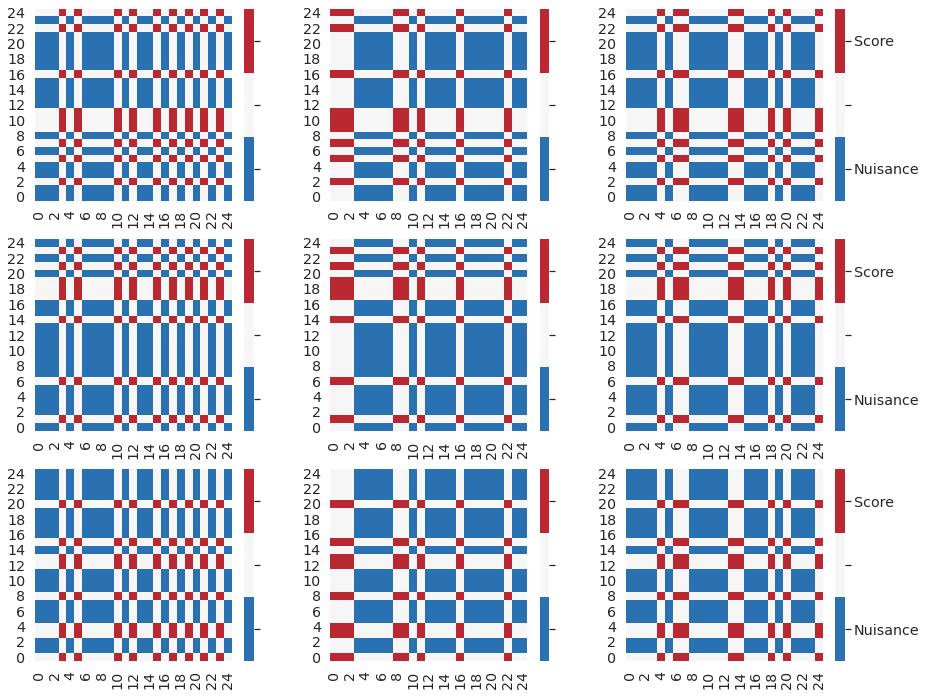

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



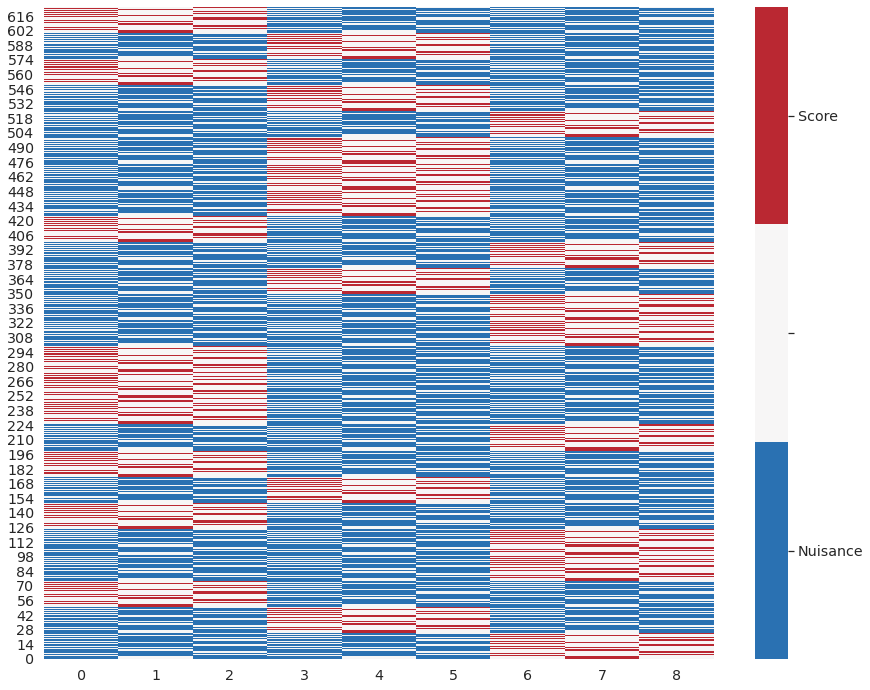

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])